# Time Series Sales Forecasting with Seasonal Autoregressive Integrated Moving-Average (ARIMA)
 
Strong seasonality in sales is apparent, as a result naive seasonal model is used as the benchmark model.

**Benchmark Scores: Seasonal Naive Forecast**
- Weighted MAE: 23,211
- MAE %: 3.64

Here, I build a few SARIMA models, and improve on the benchmark score by by 25%. The resulting model is a simple model, but it has challenges to adapt to moving holidays like Easter because the model doesn't account for those. The model however is very effective in modeling the seasonality and trend as there is no apparent pattern in model's residuals. 

Future work would involve experimentation with regression trees and neural networks, and perhaps use an ensemble of a few selected models to capture complex patterns in the data that are challenging for this model.

In [1]:
import pandas as pd
import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import utils
import plotly.express as px
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,7)
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
import itertools
import utils

## Get Store 22 Sales Data
- CPI is not going to be available at the time of forecast, but we can use the previous week's CPI.
- Adjust sale dollar amount to Consumer Price Index. This will reveal the true trend in sales regardless of varying buying power.

In [2]:
store_sales = utils.get_data(22)
store_sales = utils.adjust_cpi(store_sales)
store_sales.head()

New Index = 143, existing index = 143
Setting index to new index
New Index = 182, existing index = 182
Setting index to new index
New Index = 143, existing index = 143
Setting index to new index


Weekly_Sales  Week  IsHoliday         CPI  Weekly_Sales_Adjusted
2010-02-12    1022571.25     6       True  135.352461          755487.742119
2010-02-19     988467.61     7      False  135.411308          729974.200471
2010-02-26     899761.48     8      False  135.465778          664198.362583
2010-03-05    1009201.24     9      False  135.519519          744690.688620
2010-03-12     967187.37    10      False  135.573260          713405.702993

## Model Selection

In [3]:
data = store_sales[["Weekly_Sales_Adjusted", "IsHoliday"]] # IsHoliday is used to eval the error
data.columns = ["Weekly_Sales", "IsHoliday"]
data.head()

Weekly_Sales  IsHoliday
2010-02-12  755487.742119       True
2010-02-19  729974.200471      False
2010-02-26  664198.362583      False
2010-03-05  744690.688620      False
2010-03-12  713405.702993      False

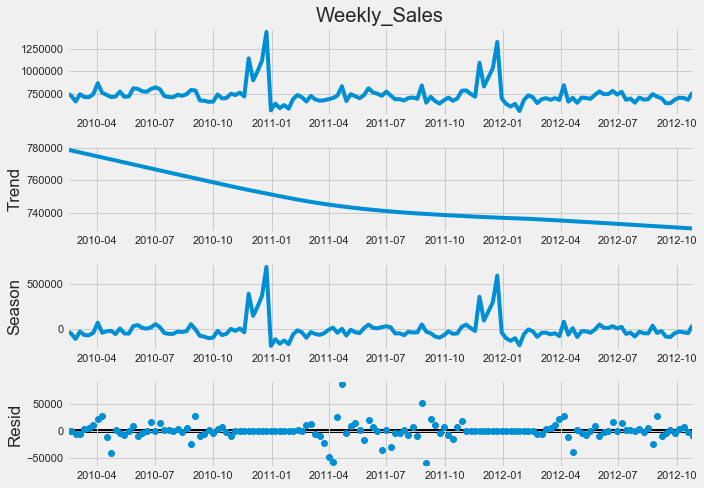

In [4]:
from statsmodels.tsa.seasonal import STL
stl = STL(data["Weekly_Sales"])
res = stl.fit()

estimated_trend = res.trend
estimated_seasonal = res.seasonal
estimated_residual = res.resid
res.plot();

### Split dataset into train and test

(130, 2) (12, 2)


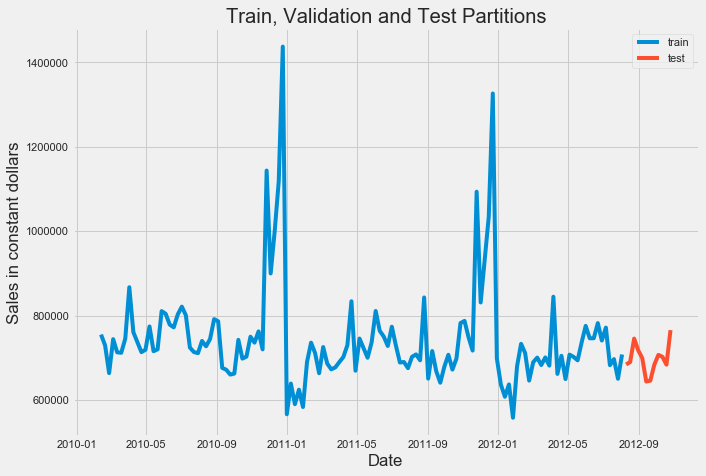

In [5]:
train, test = data.loc[:"2012-08-03"], data.loc["2012-08-10": ]
print(train.shape, test.shape)

plt.plot(train["Weekly_Sales"], label="train")
plt.plot(test["Weekly_Sales"], label="test")
plt.title("Train, Validation and Test Partitions")
plt.xlabel("Date")
plt.ylabel("Sales in constant dollars")
plt.legend();

In [6]:
train.index, test.index

(DatetimeIndex(['2010-02-12', '2010-02-19', '2010-02-26', '2010-03-05',
                '2010-03-12', '2010-03-19', '2010-03-26', '2010-04-02',
                '2010-04-09', '2010-04-16',
                ...
                '2012-06-01', '2012-06-08', '2012-06-15', '2012-06-22',
                '2012-06-29', '2012-07-06', '2012-07-13', '2012-07-20',
                '2012-07-27', '2012-08-03'],
               dtype='datetime64[ns]', length=130, freq='W-FRI'),
 DatetimeIndex(['2012-08-10', '2012-08-17', '2012-08-24', '2012-08-31',
                '2012-09-07', '2012-09-14', '2012-09-21', '2012-09-28',
                '2012-10-05', '2012-10-12', '2012-10-19', '2012-10-26'],
               dtype='datetime64[ns]', freq='W-FRI'))

In [7]:
train.head()

Weekly_Sales  IsHoliday
2010-02-12  755487.742119       True
2010-02-19  729974.200471      False
2010-02-26  664198.362583      False
2010-03-05  744690.688620      False
2010-03-12  713405.702993      False

### Plot ACF and PACF of training dataset

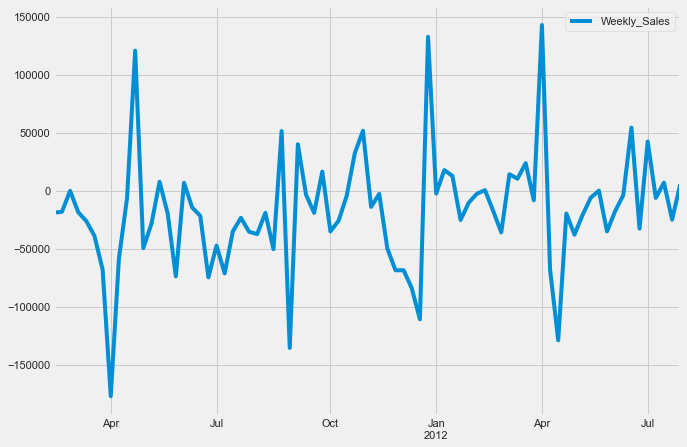

In [8]:
diffed1 = train[["Weekly_Sales"]].diff(52).dropna()
diffed1.plot();

In [9]:
diffed2 = diffed1.diff().dropna()
diffed2.plot();

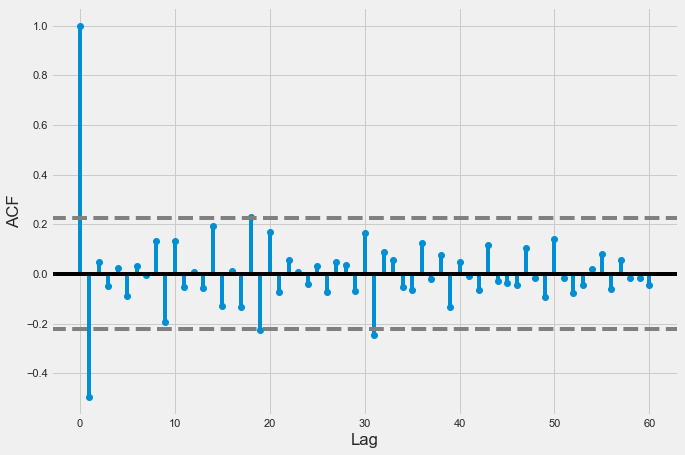

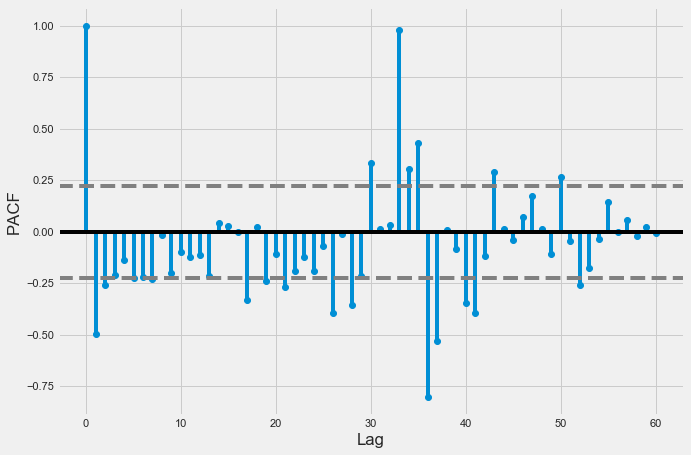

In [10]:
utils.plot_acf_pacf(diffed2);

Lag 1 ACF is negative, will use d=1

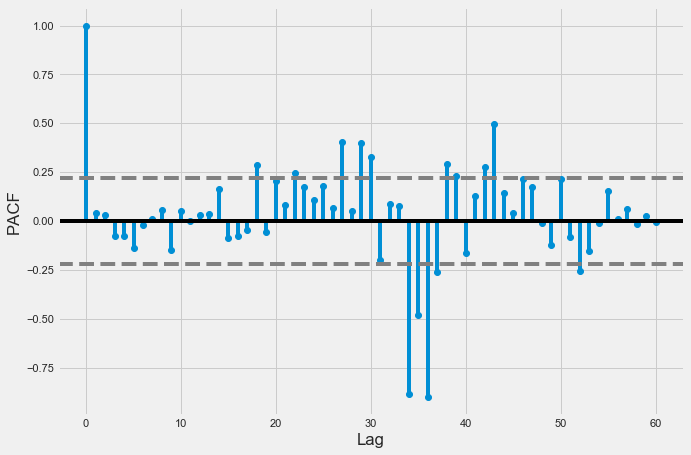

In [11]:
utils.plot_acf_pacf(diffed1);

### Seasonal with trend and AR and SMA for previous trends
- Average over the last few season's data when estimating the seasonal pattern
- Smooth trend estimate by adding MA=1
- Smooth the seasonal trend estimate by setting SMA=1

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Weekly_Sales   No. Observations:                  130
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 52)   Log Likelihood                -291.350
Date:                            Tue, 06 Apr 2021   AIC                            588.699
Time:                                    19:04:27   BIC                            592.233
Sample:                                02-12-2010   HQIC                           589.637
                                     - 08-03-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1521      0.504     -0.302      0.763      -1.140       0.836
ma.S.L52      -0.1457      0.058     -2.526      0.012      -0.259      -0.033
sigma2      2.934e+09   1.14e-11   2.58e+20      0.000    2.93e+09    2.93e+09
===================================================================================
Ljung-Box (Q):                        7.89   Jarque-Bera (JB):                19.09
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             0.98
Prob(H) (two-sided):                  0.09   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+37. Standard errors may be unstable.
"""

Forecast Error: 
Average Sales : 697893.0542933192
WMAE :  16999.756801533673
MAE %:  3.077352278746198
Model Diagnostics:



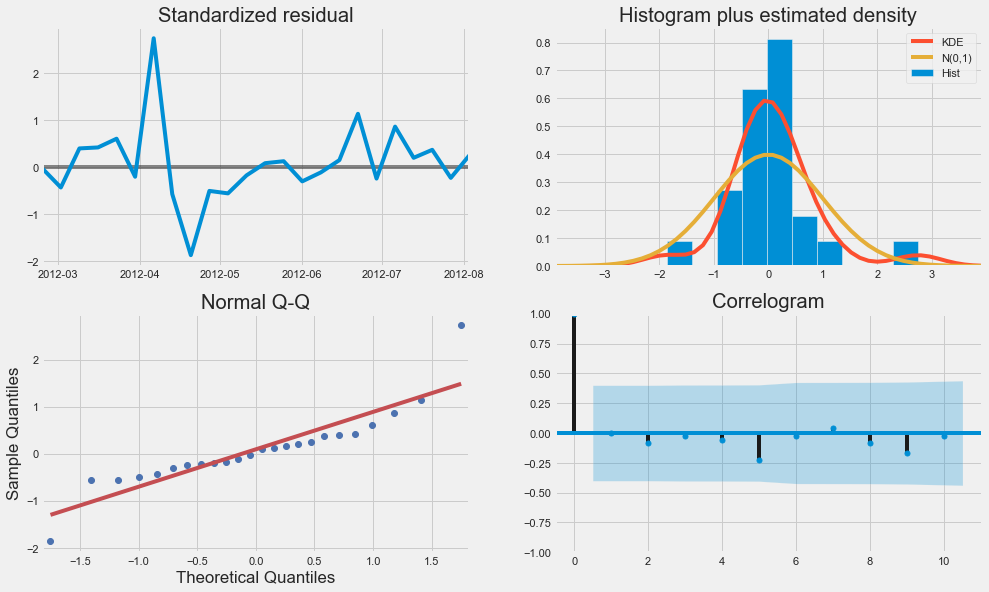

In [12]:
model, error = utils.sarimax_model(train[["Weekly_Sales"]], test, order=(0,0,1), seasonal_order=(0,1,1,52))

Score is better than the benchmark, but p value for the previous week MA is high. This model is probably not a very good fit. I will remove the non-seasonal Moving Average.

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:               Weekly_Sales   No. Observations:                  130
Model:             SARIMAX(0, 1, [1], 52)   Log Likelihood                -302.711
Date:                    Tue, 06 Apr 2021   AIC                            609.421
Time:                            19:04:29   BIC                            611.859
Sample:                        02-12-2010   HQIC                           610.098
                             - 08-03-2012                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52      -0.1467      0.055     -2.682      0.007      -0.254      -0.040
sigma2      2.496e+09   1.53e-12   1.63e+21      0.000     2.5e+09     2.5e+09
===================================================================================
Ljung-Box (Q):                        9.54   Jarque-Bera (JB):                21.06
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                             1.06
Prob(H) (two-sided):                  0.10   Kurtosis:                         6.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.72e+37. Standard errors may be unstable.
"""

Forecast Error: 
Average Sales : 697893.0542933192
WMAE :  17229.056433818107
MAE %:  3.1098987317251447
Model Diagnostics:



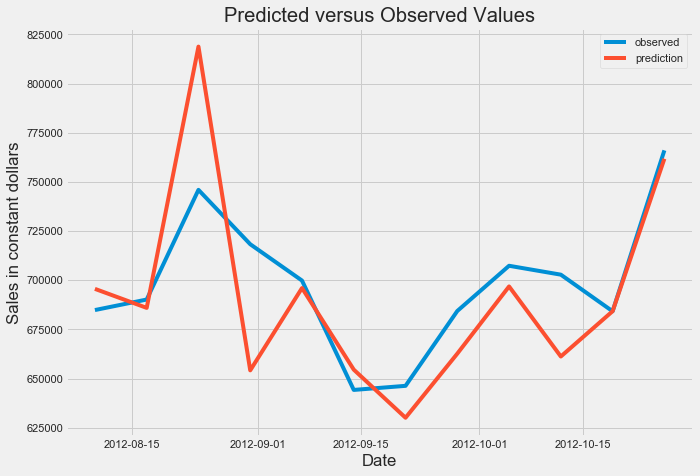

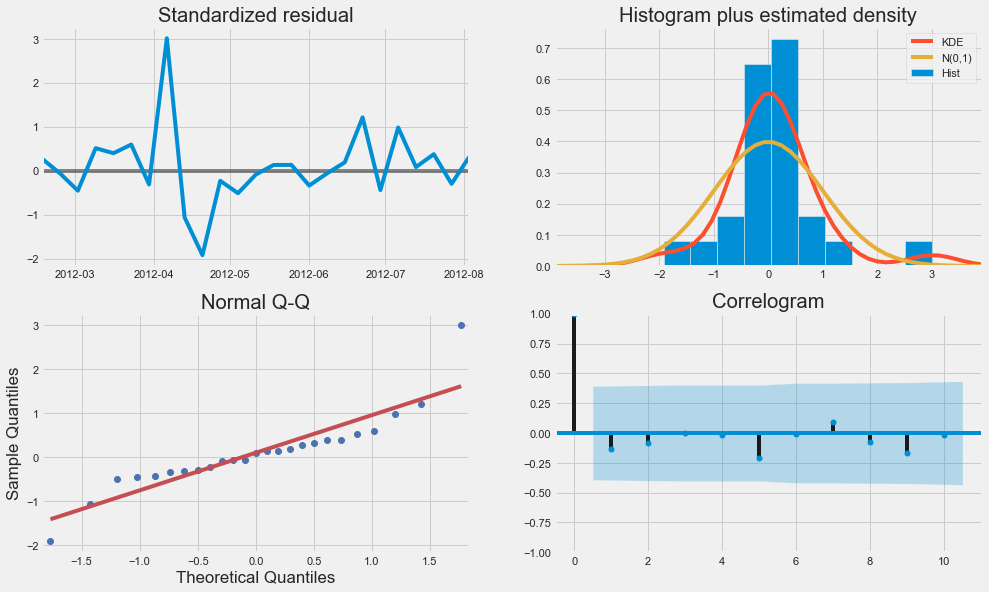

In [13]:
model, error = utils.sarimax_model(train[["Weekly_Sales"]], test, order=(0,0,0), seasonal_order=(0,1,1,52))

Got a better WMAE score and p values look good! Residuals don't appear to have any trend or seasonality. Residual distribution is centered around with heavy tails. Significant surge in sales during Easter is challenging because it is a moving holiday. This explains the heavy right tail in the residual histogram. Benchmark model had a WMAE score = 23,211. With this model's WMAE score of 17229, this is a 25% improvement.   

In [14]:
best_order =(0,0,0)
best_seasonal_order = (0, 1, 1, 52)

best_model = SARIMAX(train[["Weekly_Sales"]], order=best_order, seasonal_order=best_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_fit = best_model.fit(disp=False)
forecast = sarimax_fit.get_forecast(len(test)).summary_frame(alpha=0.05)

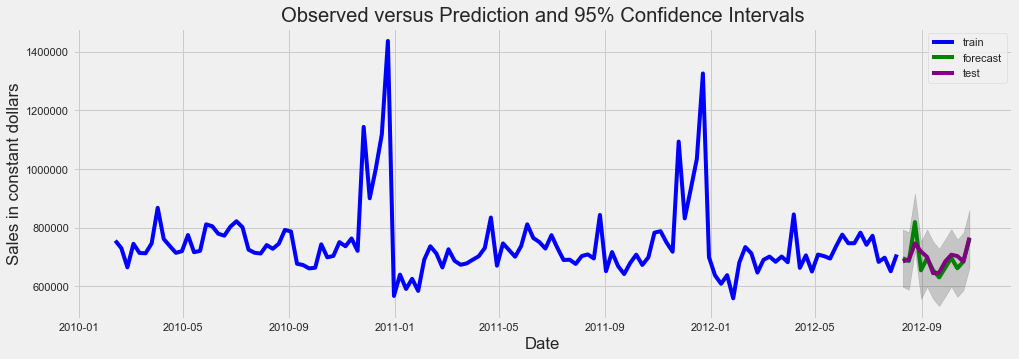

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(train[["Weekly_Sales"]], label="train", color="blue")
plt.plot(forecast['mean'], label = "forecast", color="green")
plt.plot(test[["Weekly_Sales"]], label="test", color="purple")

ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.2)
plt.xlabel("Date")
plt.ylabel("Sales in constant dollars")
plt.title("Observed versus Prediction and 95% Confidence Intervals")
plt.legend();

Forecast's confidence interval is in sync with the observed pattern, and observed values fall within forecast confidence intervals.

## Fit best model to data

Training SARIMAX with best config. Order = (0, 0, 0), SeasonalOrder = (0, 1, 1, 52)
Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:               Weekly_Sales   No. Observations:                  142
Model:             SARIMAX(0, 1, [1], 52)   Log Likelihood                -445.653
Date:                    Tue, 06 Apr 2021   AIC                            895.307
Time:                            19:04:33   BIC                            898.528
Sample:                        02-12-2010   HQIC                           896.442
                             - 10-26-2012                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52      -0.1463      0.046     -3.183      0.001      -0.236      -0.056
sigma2      2.356e+09   8.03e-13   2.94e+21      0.000    2.36e+09    2.36e+09
===================================================================================
Ljung-Box (Q):                       23.14   Jarque-Bera (JB):                28.91
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             0.78
Prob(H) (two-sided):                  0.06   Kurtosis:                         7.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.69e+37. Standard errors may be unstable.
"""

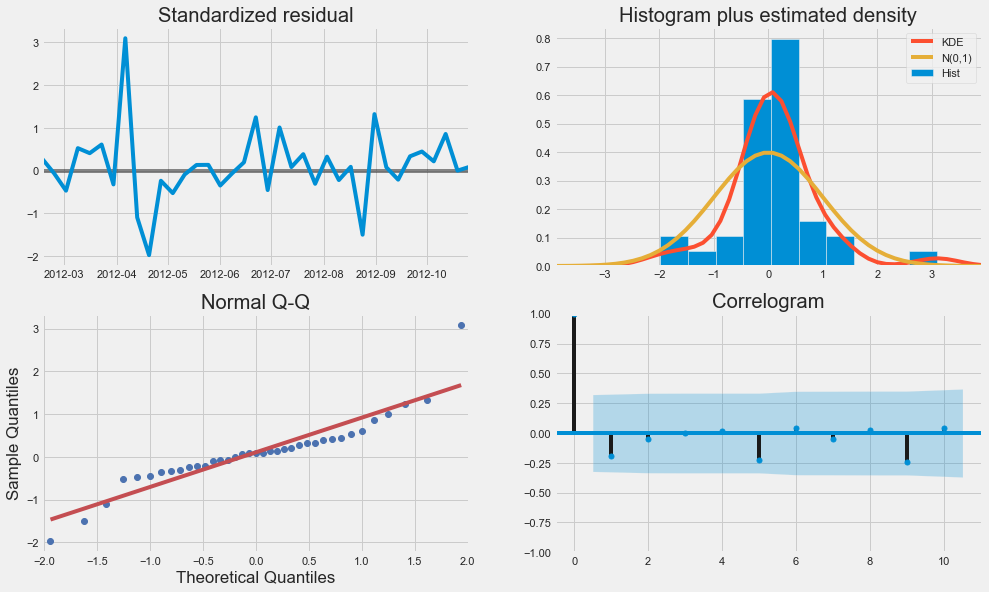

In [16]:
print("Training SARIMAX with best config. Order = {}, SeasonalOrder = {}".format(best_order, best_seasonal_order))
best_model = SARIMAX(data[["Weekly_Sales"]], order=best_order, seasonal_order=best_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_fit = best_model.fit(disp=False)
print("Model Summary:")
display(sarimax_fit.summary());

sarimax_fit.plot_diagnostics(figsize=(15, 9));

## Save ARIMA model to file
Now we have the best model, how do we serve it?
Here I'm just going to save the model to file, and reload it from the file.  Then given some new data, this loaded model will output the forecast. Next step would be to actually containeroze this model and deploy it behind a REST interface in cloud.

In [17]:
from statsmodels.tsa.arima_model import ARIMAResults
import os

artifact_path = "./artifacts"
model_name = "best_arima"

if not os.path.isdir(artifact_path):
    os.mkdir(artifact_path)

sarimax_fit.save(os.path.join(artifact_path, model_name), remove_data=False)

## Load ARIMA model and Generate Weekly Forecast for next 4 periods (month)

In [18]:
periods = 4
sarimax_fit = ARIMAResults.load(os.path.join(artifact_path, model_name))
forecast = sarimax_fit.get_forecast(periods).summary_frame(alpha=0.05)
forecast

Weekly_Sales          mean       mean_se  mean_ci_lower  mean_ci_upper
2012-11-02    7.646326e+05  48543.021728  669490.021660   8.597752e+05
2012-11-09    7.347032e+05  48543.021728  639560.646787   8.298458e+05
2012-11-16    7.026194e+05  48543.021728  607476.786986   7.977619e+05
2012-11-23    1.076691e+06  48543.021728  981548.880509   1.171834e+06

## Save forecast to file

In [19]:
forecast.to_csv(os.path.join(artifact_path, "store-forecast.csv"), index=True)